# Variation Quantum Eigen Solver 


We have gone through Shor's factoring algorithm and Grover's search algorithm. These algorithms require the 
quantum computer to do almost exactly what we program it to do-no room for (uncorrected)error. But as we are 
at the early NISQ (Noisy Intermediate-Scale Quantum) era, we cannot run long algorithms. A new type of algorithm started to appear since 2013 that focus on the getting an advantages from imperfect quantum computers called Variational-Quantum-Eigensolver(VQE). VQE is a quantum/classical hybrid algorithm that can be used to find eigenvalue of a (often large) matrix _H_(typically Hamiltonian of System). In this hybrid algorithm a quantum subrotine is run inside of a classical optimization loop.<br>

The quantum subroutine has two fundatmental steps:<br>
   1. Prepare the quantum state $|\Psi(\theta)\rangle$, often called the ansatz.<br>
   2. Measure the expectation value $\langle\,\Psi(\theta)\,|\,H\,|\,\Psi(\theta)\,\rangle$ <br>


[Variational principle](http://farside.ph.utexas.edu/teaching/qmech/Quantum/node127.html) ensures that this expectation value is always greater than the smallest eigenvalue of _H_.<br> 
This bound allows us to use classical computation to run an optimization loop to find this eigenvalue:<br>
  1. Use a classical non-linear optimizer to minimize the expectation value by varying ansatz parameters $(\theta)$.<br>
  2. Iterate until convergece. 

### Variational Form 

Variational Form: <br>
Variational Form is parameterized circuit with a fixed form and its action may be represented by the linear 
transformation $U(\theta)$. A variational form is applied to a starting state  $|\Psi\rangle$  (such as the vacuum state  $|0\rangle$ , or the Hartree Fock state) and generates an output state  $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$.Iterative optimization over $\psi(\theta)\rangle$ aims to yeild an expectation value close to minimum ground state value $\langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{min}$.<br>
While constrcuting a variational form we must balance two opposing goals.One, Ideally, our  $n$  qubit variational form would be able to generate any possible state  $|\psi\rangle$ where $|\psi\rangle \in \mathbb{C}^N$ and  $N=2^n$. Another, we would like the variational form to use as few parameters as possible.



### Example with a Single Qubit Variational Form

Use the simple single qubit variational form to solve a problem similar to ground state energy estimation. 

For the single qubit case, a variational form caple of generating any possible state is given by $U3$ gate which takes three parameters, $\theta,\phi$ and $\lambda$ <br>
\begin{align}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{align} <br>
    and its circuit ![title](figures/U3_var_form.png)

Specifically, we are given a random probability vector  $\vec{x}$   and wish to determine a possible parameterization for our single qubit variational form such that it outputs a probability distribution that is close to  $\vec{x}$

In [1]:
#Create the random probability Vector 
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
#print (target_distr)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)
print (target_distr) #This is our original state, we want our result close to this



[0.51357006 0.48642994]


In [2]:
#This block of code is to make a function that takes the parameters of our single U3 variational form as argument 
#and returns the corresponding quantum circuit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
   
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    
    return qc

In [7]:
#Now specify the objective function which takes as input a list of the variational form's parameter and returns 
#the cost associated with those parameters(how much the final state is differ from intial state)
from qiskit import Aer, execute
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    #print("Counts",counts)
    print ("Count Values",counts.values())
    #print("Output_distr",output_distr)
    #print("Target_distr",target_distr)
    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    qc = get_var_form(params)
    
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    print("Results",result.get_counts(qc))
    
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
    #display(qc.draw('mpl'))
    print('Input_distr:',target_distr)
    print('Output_distr:',output_distr)
    print('Cost',cost)
    print('-------------')
   
    return cost #This step is similar as to get the minimum energy state using variational principle

In [8]:
#Finally COBYLA optimizer is used and run the algorithm. 
from qiskit.aqua.components.optimizers import COBYLA 
# Constrained Optimization by Linear Approximation optimizer (COBYLA)

# Initialize the COBYLA optimizer

optimizer = COBYLA(maxiter=500, disp=True,tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
print ('Input parameters:->',params)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

#print("ret==>",ret)
# Obtain the output distribution using the final parameters

qc = get_var_form(ret[0])
counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Input parameters:-> [0.51943738 0.64862885 0.63905389]
Results {'0': 9317, '1': 683}
Counts {'0': 9317, '1': 683}
Count Values dict_values([9317, 683])
Input_distr: [0.51357006 0.48642994]
Output_distr: [0.9317, 0.0683]
Cost 0.8362598812611608
-------------
Results {'0': 5277, '1': 4723}
Counts {'0': 5277, '1': 4723}
Count Values dict_values([5277, 4723])
Input_distr: [0.51357006 0.48642994]
Output_distr: [0.5277, 0.4723]
Cost 0.028259881261160802
-------------
Results {'0': 5305, '1': 4695}
Counts {'0': 5305, '1': 4695}
Count Values dict_values([5305, 4695])
Input_distr: [0.51357006 0.48642994]
Output_distr: [0.5305, 0.4695]
Cost 0.03385988126116085
-------------
Results {'0': 5241, '1': 4759}
Counts {'0': 5241, '1': 4759}
Count Values dict_values([5241, 4759])
Input_distr: [0.51357006 0.48642994]
Output_distr: [0.5241, 0.4759]
Cost 0.021059881261160873
-------------
Results {'0': 950, '1': 9050}
Counts {'0': 950, '1': 9050}
Count Values dict_values([950, 9050])
Input_distr: [0.513570

# VQE Implementation in Qiskit

In this example, decompose the computation of the ground state energy of a molecule into 4 steps:<br>
1. Define a molecule and [get integrals](https://arxiv.org/pdf/1509.04279.pdf) from a computational chemistry driver (PySCF in this case) <br>
2. [Construct a Fermionic Hamiltonian and map it onto a qubit Hamiltonian](https://www.youtube.com/watch?v=DWOfMWPKHDU&list=PLZvSQ75Jheh_gUgGPC4TM7Lw3sWmdXDkh&index=23&ab_channel=Qiskit)<br>
3. [Instantiate and initialize dynamically-loaded algorithmic components, such as the quantum algorithm VQE, the optimizer and variational form it will use, and the initial_state to initialize the variational form](https://www.youtube.com/watch?v=3B04KB0pDwE&list=PLOFEBzvs-VvrXTMy5Y2IqmSaUjfnhvBHR&index=37&ab_channel=Qiskit)<br>
4. Run the algorithm on a quantum backend and retrieve the results.<br>

![title](figures/Variational_Circuit.png)

In [13]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [14]:
def get_qubit_op(dist):
    #Step 1: Define a molecule
    #Here, we use LiH in the sto3g basis with the PySCF driver as an example. 
    #The molecule object records the information from the PySCF driver.
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    #sto3g-> small toy model
    molecule = driver.run()
    #ferOp_nofreeze=FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)

    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy 
    #under Born Opperhiemer Approximation all the nuclei are stationary 
    #so their contribution to the ground state energy is only nuclear repulsion. 
    #print(repulsion_energy) #in Hatree Unit
    
    num_particles = molecule.num_alpha + molecule.num_beta #number of electrons in the system
    #print("number of particles==>",num_particles) #4
    num_spin_orbitals = molecule.num_orbitals * 2 #number of spin orbital is twice of that space orbitals
    
    
    print("number of spin orbitals",num_spin_orbitals)
    #as spin degeneracy is 2
    remove_list = [x % molecule.num_orbitals for x in remove_list] 
    #% in interpreted language: Reminder=dividend-divisor*floor(quotient)
    #==> R_0 = -3 -6*(-1) = +3 and R_1= -2-6*(-1) = +4 
    
    #print ('freeze_list=>',freeze_list) #[0]
    #print ('Remove list=>',remove_list) #[3,4]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    #print ('freeze_list=>',freeze_list) #[0]
    #print ('Remove list=>',remove_list) #[2,3]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    print ('Remove list=>',remove_list) #[2,3,7,8]
    print ('freeze_list=>',freeze_list) #[0,6]
    
    
    #Define Fermionic Operator
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)# the frozen electron(2 inner electron from Li+) 
    #do not interact with other electrons but contribute by a constant term to the total ground state energy
    num_spin_orbitals -= len(freeze_list) #rescale num_spin_orbiatls after freeze list
    num_particles -= len(freeze_list) 
    print("number of particles==>",num_particles) #print=>2 
    
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    h1=molecule.one_body_integrals
    h2=molecule.two_body_integrals
    #print('one body integral=>')
    #print (ferOp_nofreeze.h1) #intialially it has 12 
    #print('one body integral after freezeing and removing')
    #print(ferOp.h1) # after applying freeze and remove it drop down to 6 
    #print('-------------------------------------------')
    #print('two body integrals=>')
    #print(ferOp.h2)
    #print ('------------------------------')
    num_spin_orbitals -= len(remove_list)
    #print("========================Fermionic Operator After applying freezing and removing list==================")
    #print (ferOp)
    
    #Create a Qubit Operator 
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    #print ("=====Qubit Operator berfore applying parity========")
    
    print(qubitOp) # qubits is 6 which is same as fermionic operator after applying freezing and removing list
    
    print(Z2Symmetries.find_Z2_symmetries(qubitOp))#Show spin and charge symmetries, so two conserved quantities
    #which will further helps to reduce the qubitOp
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy 
    #shift is the enegy comming from repulsion energy of two nuclei under Born–Oppenheimer approximation and
    #and freezing two electrons
    #print("-----------------Qubit Operator after appying parity---------------------")
    #print (qubitOp) # give type of operator(paulis) working on number of qubits(6) and number of paulis operator 
    #print(qubitOp.print_details()) 
    return qubitOp, num_particles, num_spin_orbitals, shift






number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


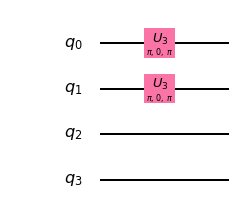

Number of Parameters 8
Interatomic Distance: 0.5 VQE Result: -7.039673439126495 Exact Energy: [-7.03973252]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


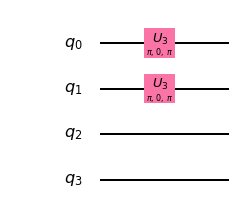

Number of Parameters 8
Interatomic Distance: 0.6 VQE Result: -7.313308878328012 Exact Energy: [-7.31334583]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


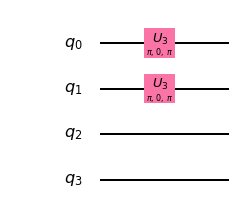

Number of Parameters 8
Interatomic Distance: 0.7 VQE Result: -7.500887036027975 Exact Energy: [-7.50092209]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


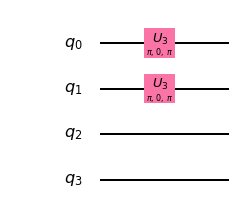

Number of Parameters 8
Interatomic Distance: 0.8 VQE Result: -7.630945408791781 Exact Energy: [-7.63097825]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


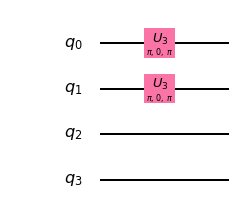

Number of Parameters 8
Interatomic Distance: 0.9 VQE Result: -7.720781098034483 Exact Energy: [-7.72081241]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


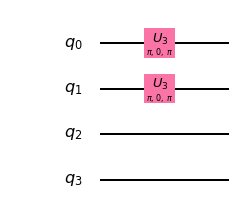

Number of Parameters 8
Interatomic Distance: 1.0 VQE Result: -7.782211600637968 Exact Energy: [-7.7822424]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


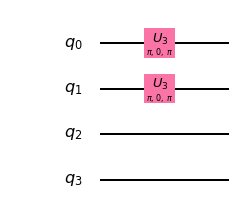

Number of Parameters 8
Interatomic Distance: 1.1 VQE Result: -7.823568084997525 Exact Energy: [-7.82359928]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


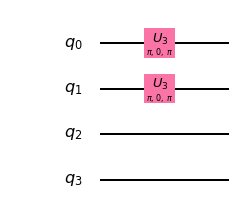

Number of Parameters 8
Interatomic Distance: 1.2 VQE Result: -7.850666130879816 Exact Energy: [-7.85069838]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


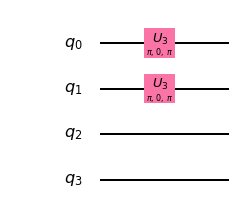

Number of Parameters 8
Interatomic Distance: 1.3 VQE Result: -7.867529586369839 Exact Energy: [-7.86756329]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


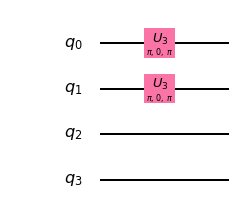

Number of Parameters 8
Interatomic Distance: 1.4 VQE Result: -7.87696625052147 Exact Energy: [-7.87700149]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


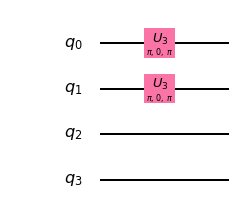

Number of Parameters 8
Interatomic Distance: 1.5 VQE Result: -7.880979502349552 Exact Energy: [-7.88101572]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


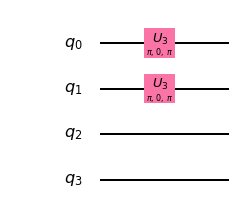

Number of Parameters 8
Interatomic Distance: 1.6 VQE Result: -7.881036615597765 Exact Energy: [-7.88107204]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


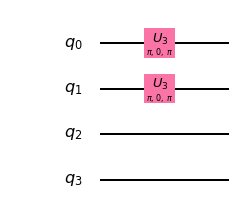

Number of Parameters 8
Interatomic Distance: 1.7 VQE Result: -7.878236970762594 Exact Energy: [-7.87826817]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


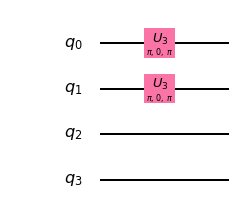

Number of Parameters 8
Interatomic Distance: 1.8 VQE Result: -7.873345233671697 Exact Energy: [-7.87344029]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


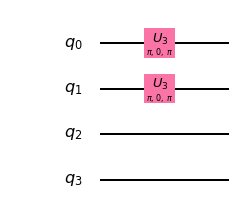

Number of Parameters 8
Interatomic Distance: 1.9 VQE Result: -7.867137512401303 Exact Energy: [-7.86723396]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


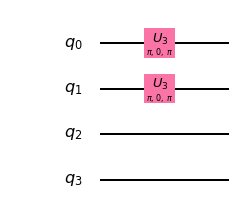

Number of Parameters 8
Interatomic Distance: 2.0 VQE Result: -7.8600683723274365 Exact Energy: [-7.86015321]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


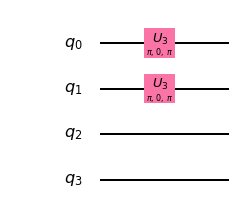

Number of Parameters 8
Interatomic Distance: 2.1 VQE Result: -7.852535256464017 Exact Energy: [-7.85259583]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


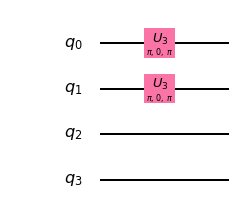

Number of Parameters 8
Interatomic Distance: 2.2 VQE Result: -7.844839387871353 Exact Energy: [-7.84487909]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


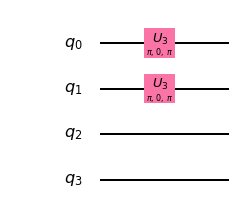

Number of Parameters 8
Interatomic Distance: 2.3 VQE Result: -7.837212715811175 Exact Energy: [-7.83725797]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


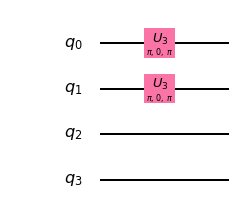

Number of Parameters 8
Interatomic Distance: 2.4 VQE Result: -7.829853252523495 Exact Energy: [-7.829937]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


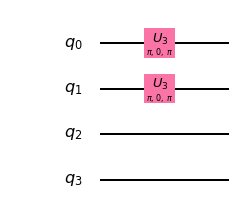

Number of Parameters 8
Interatomic Distance: 2.5 VQE Result: -7.822930312469663 Exact Energy: [-7.82307664]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


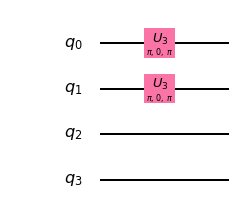

Number of Parameters 8
Interatomic Distance: 2.6 VQE Result: -7.816588408309776 Exact Energy: [-7.81679515]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


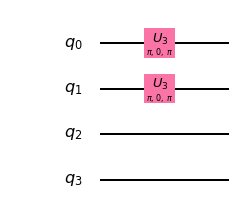

Number of Parameters 8
Interatomic Distance: 2.7 VQE Result: -7.810934374278975 Exact Energy: [-7.81116828]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


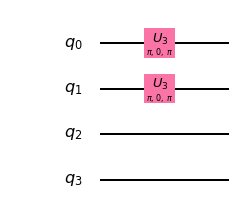

Number of Parameters 8
Interatomic Distance: 2.8 VQE Result: -7.806014869936971 Exact Energy: [-7.80622956]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


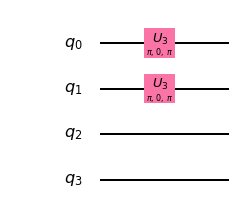

Number of Parameters 8
Interatomic Distance: 2.9 VQE Result: -7.801736620358109 Exact Energy: [-7.8019736]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


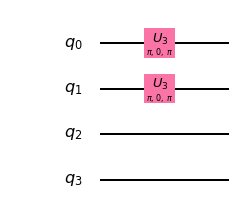

Number of Parameters 8
Interatomic Distance: 3.0 VQE Result: -7.798083535616146 Exact Energy: [-7.79836343]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


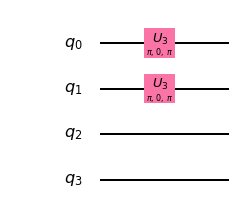

Number of Parameters 8
Interatomic Distance: 3.1 VQE Result: -7.795060172761516 Exact Energy: [-7.79534045]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


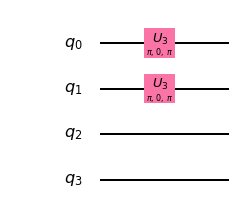

Number of Parameters 8
Interatomic Distance: 3.2 VQE Result: -7.792367399914658 Exact Energy: [-7.79283481]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


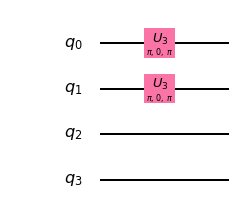

Number of Parameters 8
Interatomic Distance: 3.3 VQE Result: -7.7896861037457565 Exact Energy: [-7.79077401]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


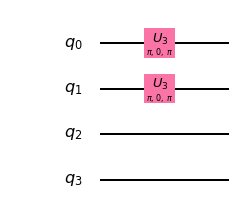

Number of Parameters 8
Interatomic Distance: 3.4 VQE Result: -7.787375464523038 Exact Energy: [-7.7890889]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


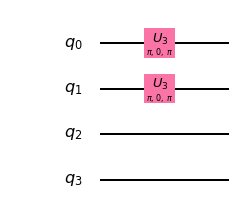

Number of Parameters 8
Interatomic Distance: 3.5 VQE Result: -7.785627429382009 Exact Energy: [-7.78771697]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


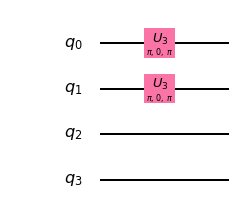

Number of Parameters 8
Interatomic Distance: 3.6 VQE Result: -7.784375141534188 Exact Energy: [-7.78660376]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


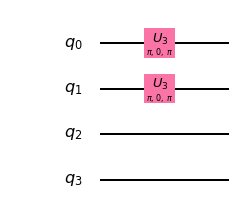

Number of Parameters 8
Interatomic Distance: 3.7 VQE Result: -7.783495992431577 Exact Energy: [-7.78570291]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


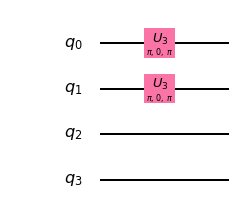

Number of Parameters 8
Interatomic Distance: 3.8 VQE Result: -7.782885682995436 Exact Energy: [-7.78497559]
number of spin orbitals 12
Remove list=> [2, 3, 7, 8]
freeze_list=> [0, 6]
number of particles==> 2
Representation: paulis, qubits: 6, size: 118
Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
IIIZII	(0.7071067811865475+0j)
IIIXII	(0.7071067811865475+0j)

ZIIIII	(0.7071067811865475+0j)
XIIIII	(0.7071067811865475+0j)

Qubit index:
[2, 5]
Tapering values:
  - Possible values: [1, 1], [1, -1], [-1, 1], [-1, -1]
[False False  True  True]


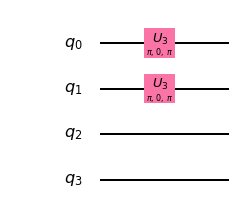

Number of Parameters 8
Interatomic Distance: 3.9 VQE Result: -7.78246666405225 Exact Energy: [-7.78438961]
All energies have been calculated


In [15]:
backend = BasicAer.get_backend("statevector_simulator")
#distances=[1.6]
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
#Sequential Least SQuares Programming optimizer (SLSQP)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist) #Returing multiple values in python function
    result = NumPyEigensolver(qubitOp).run() #Just to check with result obtained from VQE
    exact_energies.append(np.real(result.eigenvalues) + shift)
    #Create initial Guess state(Ansatz)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    print(initial_state.bitstr)
    HF_circuit=initial_state.construct_circuit('circuit')
    display(HF_circuit.decompose().draw(output='mpl')) #inital Hatree Fock state
    
    #UCCSD is used as problem has one and two body integral
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    #print(var_form.single_excitations)
    print("Number of Parameters",var_form.num_parameters)
    #var_circuit=var_form.construct_circuit([2])
    #display(var_circuit.decompose().draw('mpl'))
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

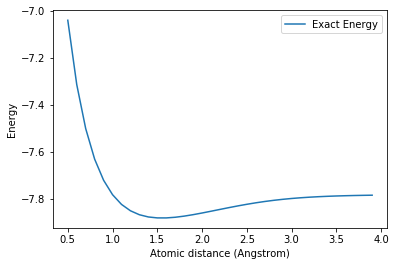

In [19]:
plt.plot(distances, exact_energies, label="Exact Energy")
#plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

# Creating Variational Ansatz




two_qubit_reduction only works with parity qubit mapping but you have jordan_wigner. We switch two_qubit_reduction to False.


[False  True False  True]


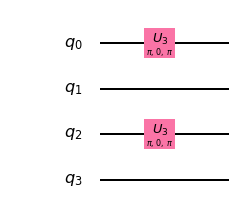

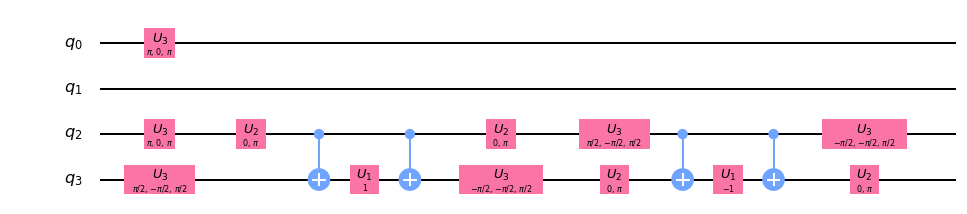

In [57]:
init_state=HartreeFock(num_orbitals=4,num_particles=2,qubit_mapping='jordan_wigner')
print(init_state.bitstr) #give fermionic mode on which particle are occupied
HF_circuit=init_state.construct_circuit('circuit')
display(HF_circuit.decompose().draw('mpl'))
UCCSD_var_form=UCCSD(num_orbitals=4,num_particles=2,qubit_mapping='jordan_wigner',excitation_type='s',
                    method_singles='beta',initial_state=init_state,two_qubit_reduction=False,reps=1)
var_circuit=UCCSD_var_form.construct_circuit([1])
var_circuit.decompose().draw(output='mpl')
#print(UCCSD_var_form.single_excitations)